# Sentence Mapper

In [223]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
from rich import print
from datasets import load_dataset


from src.pipeline import SentenceMapperPipeline
from src.visualization import SentenceMapperVisualizer
from src.sentence_processor import SentenceProcessor
from src.map_reduce_summarizer import MapReduceSummarizer

# Suppress langchain text splitter warnings
logging.getLogger('langchain_text_splitters.base').setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Some Data

For this example, we will use one report from the **GovReports dataset**, which is a long document summarization dataset, with about 19.5k reports published by the U.S. Government Accountability Office (GAO) and Congressional Research Service (CRS).

They cover researches on a broad range of national policy issues, including health care, education, national security, economics, and the environment.


Reference: https://arxiv.org/pdf/2104.02112

## Multi-LexSum

Is a collection of 9,280 such legal case summaries. It presents a challenging multi-document summarization task given the long length of the source documents, often exceeding two hundred pages per case. Experts—lawyers and law students—are trained to follow carefully created guidelines, and their work is reviewed by an additional expert to ensure quality.

Reference: Shen et al. 2022 https://arxiv.org/pdf/2206.10883

In [258]:
# Download one sample from the train split.

split = "train"
index = 0

govreport = load_dataset("ccdv/govreport-summarization", split=f"{split}[:50]")
report = govreport[index]["report"]
reference_summary = govreport[index]["summary"]
print(f"Report:\n{report[:500]}...\n")
print(f"Reference Summary:\n{reference_summary[:500]}...\n")

#multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")

# Download multi_lexsum locally and load it as a Dataset object 

#example["sources"] # A list of source document text for the case

Report:
The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the 
structure—active duty military personnel, reservists, defense contractors, host nation military and civilian 
personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian 
personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the
countries of Bosnia-Herzegovina, Croatia, and Hung...

Reference Summary:
As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed departmen...

## Sentence Processor

Splits the full document into sentences, then for each sentence builds a centered context window of complete surrounding sentences (excluding the target sentence itself) up to a character budget. Cosine similarity is
computed between the sentence embedding and its context embedding, giving a clean representativeness signal without self-overlap artifacts.

It requires 2 parameters: 

- context_budget: Maximum character budget for the context window surrounding each sentence (default: 2048)
- min_sentence_length: Minimum sentence length in characters. Shorter sentences are merged (default: 256)
 

SentenceProcessor uses model2vec to get embeddings super fast. 

Some domains may use specific abbreviations or prefixes that can confuse the sentence splitter. These prefixes can be passed in custom_parameters, so they are do not end sentences.


For the GovReports dataset, we can add some common abbreviations:
- **U.S.** (United States)
- **H.R.** (House Resolution)
- **H.Rept.** (House Report)
- **P.L.** (Public Law)
- **S.** (Senate bill)

In [259]:
custom_parameters = {
    "prefixes": [
        "H.R", "H.Rept", "S", "P.L", "Rep", "Sen", "S.Rept",
        "U.S", "N.Y", "Calif", "U.N"
    ],
    "additional_replacements": {
        "U.": "U<prd>",
        "S.": "S<prd>",
        "U.S.": "U<prd>S<prd>",
        "U.S.A.": "U<prd>S<prd>A<prd>",
        "i.e.": "i<prd>e<prd>",
        "e.g.": "e<prd>g<prd>",
        "Ph.D.": "Ph<prd>D<prd>",
        "et al.": "et<prd>al<prd>",
    }
}

# Initialize processor with custom splitter for government reports
processor = SentenceProcessor(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters
)

visualizer = SentenceMapperVisualizer()

Total sentences: 259

Total tokens: 11023

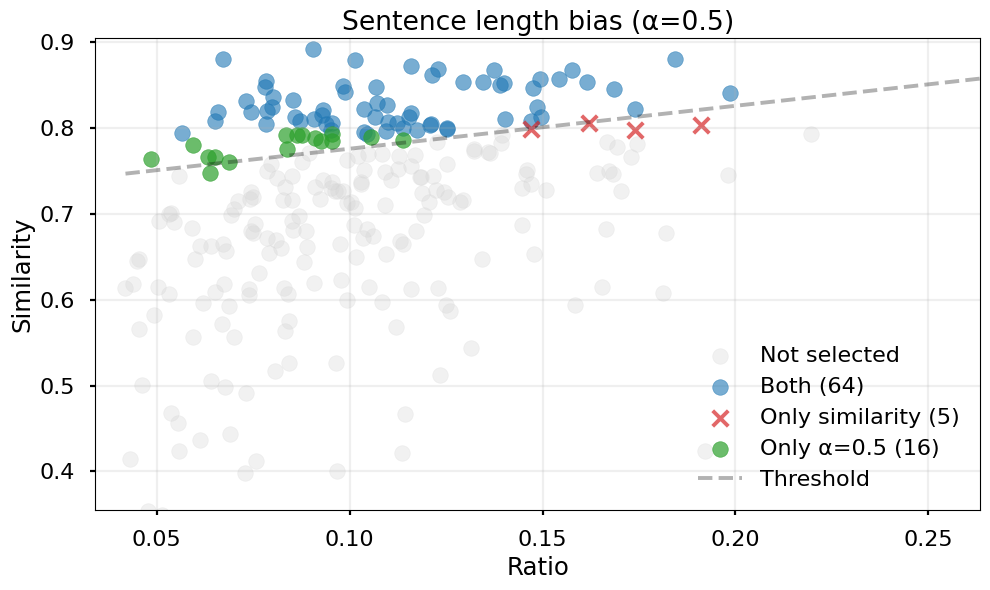

In [296]:
features = processor.compute_document_features(text=report)

print(f"Total sentences: {len(features['similarities'])}")
print(f"Total tokens: {features['total_tokens']}")



fig = SentenceMapperVisualizer.plot_similarity_vs_ratio(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    length_bias=0.5,
    title="Sentence length bias (α=0.5)",
    save_path="data/img/similarity_vs_ratio_plot.png"
)

plt.show()

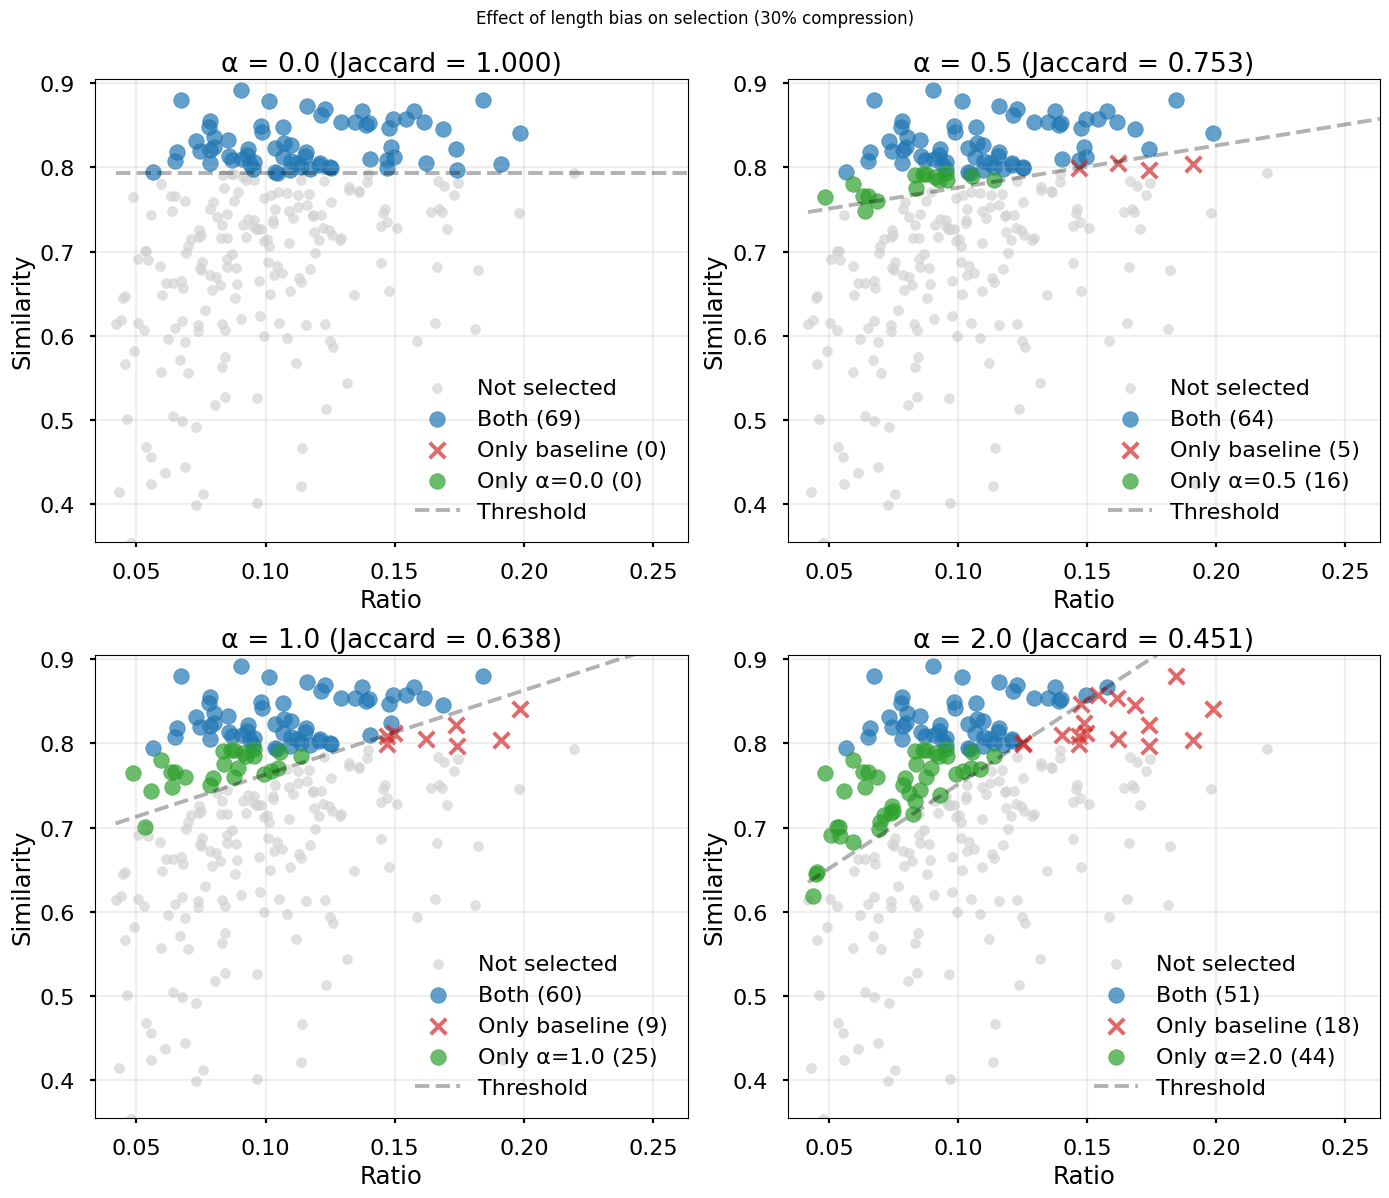

In [295]:
# 2x2 grid comparing different alpha values at 30% compression
fig = visualizer.plot_similarity_vs_ratio_multiple_alphas(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    alphas=[0.0, 0.5, 1.0, 2.0],
    title="Effect of length bias on selection (30% compression)",
    save_path="data/img/similarity_vs_ratio_plot_multiple_alphas.png"
)
plt.show()

## Scoring & Selection

Each sentence is scored by:

```
score = similarity - α × ratio
```

Where `α` (length_bias, default 0.5) is a linear penalty that mildly favours shorter sentences at equal similarity. With `α = 0`, this is pure similarity ranking.

The additive form composes naturally with future bias terms (e.g. `+ β × query_similarity` for semantic-biased extraction).

Sentences are ranked by score and greedily selected until the token budget is reached.

## Extract the best sentences

`SentenceMapperPipeline.process_document` computes features, scores, and selects the top sentences to fill the token budget.

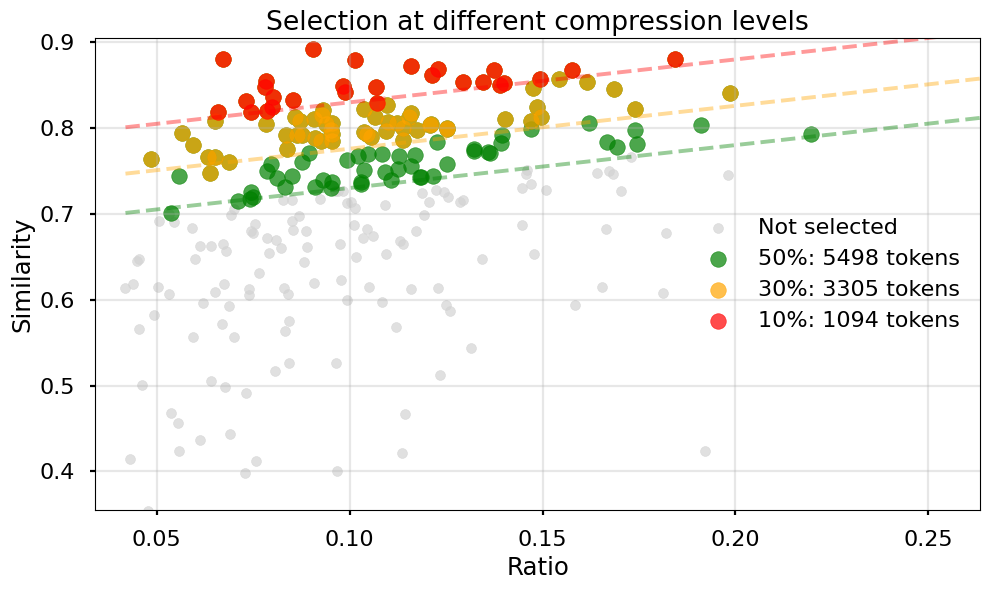

In [293]:
# Initialize pipeline with custom splitter
pipeline = SentenceMapperPipeline(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters,
    length_bias=0.5,
)

objective_percentages = [0.1, 0.3, 0.5]

results = []
for pct in objective_percentages:
    r = pipeline.process_document(text=report, objective_percentage=pct)
    results.append(r)

# Show selections at different compression levels
SentenceMapperVisualizer.plot_similarity_vs_ratio_multiple_objectives(
    similarities=features['similarities'],
    ratios=features['ratios'],
    results=results,
    objective_percentages=objective_percentages,
    title="Selection at different compression levels"
)


See the selected sentences highlighted in the HTML file.

In [297]:
result = results[1]  # Get the result for the 30% objective
percentage = objective_percentages[1]

SentenceMapperVisualizer.export_highlighted_text(
    sentences=features['sentences'],
    mask=result['mask'],
    output_path=f"data/html/{split}_{index}_{percentage*100:.0f}.html"
)

In [298]:
# Display the first 3 chunks with highlighted sentences
SentenceMapperVisualizer.display_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    title=f"Selected Sentences ({percentage*100:.0f}% compression)",
    dark_mode=True,
    max_display_tokens=500
)

In [300]:
# Interactive plot — baseline vs length-biased with sentence hover
visualizer = SentenceMapperVisualizer()

fig = visualizer.plot_similarity_vs_ratio_interactive(
    similarities=features["similarities"],
    ratios=features["ratios"],
    tokens=features["tokens"],
    sentences=result["sentences"],
    objective_percentage=percentage,
    length_bias=result["length_bias"],
    title=f"Baseline vs α={result['length_bias']} ({percentage:.0%} target)",
)

## Map - Reduce Summarization

Traditional map-reduce is token expensive. Summarizing section into intermediate summaries (map step), and then generating the final summary is expensive.

After extracting the most information-dense sentences, we can pass them to a LLM to generate a summary spanning the whole document. 
LLM's nowadays are intelligent enough to understand the document even with 70-80% missing context. 


In [317]:
summarizer = MapReduceSummarizer(
    summarize_model="gpt-4.1",
    judge_model="gpt-5-mini",
)

In [311]:
llm_summary = summarizer.summarize_with_llm(text=result["selected_text"])

In [312]:
# Compare with the human reference summary
print("\n[bold]Generated Summary:[/bold]\n")
print(llm_summary)
print("\n[bold]Reference Summary:[/bold]\n")
print(reference_summary)

Generated Summary:

The Department of Defense (DOD) established the emergency-essential program in 1985 to ensure that federal civilian
employees could be deployed to combat zones and perform critical support functions. To safeguard the health of 
deployed civilian personnel, DOD implemented force health protection and surveillance policies focused on 
assessing, reducing, and preventing health risks. These policies mandate that all deploying civilians complete 
pre-deployment health assessment forms within 30 days of deployment, with health care providers reviewing them to 
confirm fitness and identify any need for further evaluation. Pre-deployment and post-deployment health 
assessments, as well as required immunizations, are key parts of these policies, aiming to verify medical readiness
and address health or exposure concerns arising from deployments in theaters such as Afghanistan and Iraq.

In a comprehensive review of federal civilian deployment records from selected DOD components, it was found that 
while most records complied with the health assessment requirements, some gaps remained. Out of 3,771 deployment 
records reviewed, 52 lacked documentation of pre-deployment health assessments, and 285 were missing evidence of at
least one required immunization. Army component locations demonstrated especially strong compliance, but these 
disparities indicated that DOD’s policies were not being fully and consistently implemented across all components. 
DOD also lacked mechanisms to centrally track or report the locations and movements of its deployed civilian 
personnel, limiting oversight and accountability regarding deployment and associated health risks.

Recognizing these shortcomings, DOD’s Office of the Under Secretary of Defense for Personnel and Readiness issued 
revised policy and program guidance in August 2006, calling for more comprehensive and centralized deployment and 
health information for federal civilians. However, while the new policy included requirements for components to 
report specific health and location data, it did not establish an oversight or quality assurance mechanism to 
ensure complete and consistent implementation. In comparison, previous assessments and a related legislative 
mandate prompted DOD to create a similar oversight mechanism to monitor force health protection for military 
servicemembers.

With respect to medical care, DOD federal civilians deployed to combat zones receive care through the military 
health system’s four levels of care if injured or ill, and can claim workers’ compensation benefits under the 
Federal Employees’ Compensation Act if eligible. A sample review of seven compensation claims (from a universe of 
83) for deployed civilians found that, in all cases, the individuals had received medical care consistent with DOD 
policies, both in the theater of operations and upon return to the United States.

Compensation and benefits for DOD federal civilian personnel differ in several respects from those for military 
personnel. Both groups are eligible for compensation to reflect the risks and conditions of deployment, but the 
types and amounts of special pays and allowances vary. For example, federal civilians deployed to Afghanistan and 
Iraq are eligible for post (hardship) differential and danger pay, each equivalent to 35 percent of base salary, 
while military personnel may also receive family separation allowances—a benefit not available to civilians. 
Conversely, federal civilians can receive premium pay, such as overtime and night differential, not available to 
the military. Modeling compensation scenarios showed that, depending on pay grade and deployment circumstances, 
overall compensation could be higher for civilians than for military personnel in some situations.

Disability benefits in the event of deployment-related injury or illness also differ. Civilian disability 
compensation is based on salary and dependent status, while military personnel receive payments base

Reference Summary:

As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed department officials to determine the extent to which DOD has established and the
military services and defense agencies (hereafter referred to as DOD components) have implemented (1) force health 
protection and surveillance policies and (2) medical treatment policies and procedures for its deployed federal 
civilians. GAO also examined the differences in special pays and benefits provided to DOD's deployed federal 
civilians and military personnel. DOD has established force health protection and surveillance policies to assess 
and reduce or prevent health risks for its deployed federal civilian personnel, but it lacks procedures to ensure 
implementation. Our review of over 3,400 deployment records at eight component locations found that components 
lacked documentation that some federal civilian personnel who deployed to Afghanistan and Iraq had received, among 
other things, required pre- and post-deployment health assessments and immunizations. These deficiencies were most 
prevalent at Air Force and Navy locations, and one Army location. As a larger issue, DOD lacked complete and 
centralized data to readily identify its deployed federal civilians and their movement in theater, further 
hindering its efforts to assess the overall effectiveness of its force health protection and surveillance 
capabilities. In August 2006, DOD issued a revised policy which outlined procedures that are intended to address 
these shortcomings. However, these procedures are not comprehensive enough to ensure that DOD will know the extent 
to which its components are complying with existing health protection requirements. In particular, the procedures 
do not establish an oversight and quality assurance mechanism for assessing the implementation of its force health 
protection and surveillance requirements. Until DOD establishes a mechanism to strengthen its force health 
protection and surveillance oversight, it will not be effectively positioned to ensure compliance with its 
policies, or the health care and protection of deployed federal civilians. DOD has also established medical 
treatment policies for its deployed federal civilians which provide those who require treatment for injuries or 
diseases sustained during overseas hostilities with care that is equivalent in scope to that provided to active 
duty military personnel under the DOD military health system. GAO reviewed a sample of seven workers' compensation 
claims (out of a universe of 83) filed under the Federal Employees' Compensation Act by DOD federal civilians who 
deployed to Iraq. GAO found in three cases where care was initiated in theater, that the affected civilians had 
received treatment in accordance with DOD's policies. In all seven cases, DOD federal civilians who requested care 
after returning to the United States had, in accordance with DOD's policies, received medical examinations and/or 
treatment for their deployment-related injuries or diseases through either military or civilian treatment 
facilities. DOD provides certain special pays and benefits to its deployed federal civilians, which generally 
differ in type and/or amount from those provided to deployed military personnel. For example, both civilian and 
military personnel are eligible to receive disability benefits for deployment-related injuries; however, the type 
and amount of these benefits vary, and some are unique to each group. Further, while the survivors of deceased 
federal civilian and military personnel ge

In [313]:
from src.map_reduce_summarizer import calculate_rouge_scores

print(f"Input length: {len(report)} characters")
print(f"Extracted sentences lenght: {len(result["selected_text"])}")
print(f"Reference summary length: {len(reference_summary)} characters")
print(f"Generated summary lenght: {len(llm_summary)}")

rouge_scores = calculate_rouge_scores(reference_summary, llm_summary)

print(f"  ROUGE-1 F1: {rouge_scores['rouge1']:.4f}")
print(f"  ROUGE-2 F1: {rouge_scores['rouge2']:.4f}")
print(f"  ROUGE-L F1: {rouge_scores['rougeL']:.4f}")


Input length: 62042 characters

Extracted sentences lenght: 19320

Reference summary length: 4074 characters

Generated summary lenght: 5787

ROUGE-1 F1: 0.5822

ROUGE-2 F1: 0.1948

ROUGE-L F1: 0.2365

## LLM-Judge and Future Work

We can use a LLM-as-a-Judge to identify the most salient differences.

In the future, SentenceMapper will support the use of a "semantic-bias". A list of keywords or keyphrases that
are relevant for the dataset. They should increase the likelihood of sentences containing them to be extracted.

The LLM-as-a-Judge model can also suggest guidelines for the summarizer.
This infomation can be used to improve the summarization prompt.

Evaluate a small sample of summaries of the dataset, to get a representative list of both, keywords and guideance. Implementing both strategies should improve the quality of the summaries.

In [315]:
judge_evaluation

{'error': 'Failed to parse JSON response', 'raw_response': ''}

In [318]:
judge_evaluation = summarizer.judge_with_llm(
        generated_summary=llm_summary, 
        reference_summary=reference_summary,
        compression_ratio=30,
    )

print("[bold]Strengths:[/bold]", judge_evaluation.get("strengths", "N/A"))
print("\n[bold]Gaps:[/bold]", judge_evaluation.get("gaps", "N/A"))
print("\n[bold]Semantic bias:[/bold]", judge_evaluation.get("semantic_bias", "N/A"))
print("\n[bold]Guidance:[/bold]", judge_evaluation.get("guidance", "N/A"))
print("\n[bold]Overall score:[/bold]", judge_evaluation.get("overall_score", "N/A"))

Strengths: The generated summary captures the report's main themes: DOD force health protection and surveillance 
policies for deployed civilian employees, gaps in implementation and documentation, the lack of centralized 
tracking of deployed civilians, issuance of revised August 2006 policy guidance, equivalence of medical treatment 
for deployed civilians, and differences in compensation, disability, and survivor benefits between civilians and 
military personnel. It also summarizes the review methodology (deployment record review and workers' compensation 
case review) and is generally clear and well organized.

Gaps: Important issues from the reference that are missing or misrepresented: (1) The generated summary misstates 
or contradicts key findings about which components had the most prevalent deficiencies — the reference highlights 
that deficiencies were most prevalent at Air Force and Navy locations (and one Army location), whereas the 
generated text portrays Army locations as especially strong. (2) The workers' compensation sample findings are 
misreported: the reference specifies that in three of the cases care was initiated in theater and those cases 
complied with policy, and that all seven who requested care after return received examinations/treatment; the 
generated summary overgeneralizes that all cases received care both in theater and upon return. (3) The generated 
text includes inconsistent and likely incorrect counts (mentions 3,771 records in one place and 3,431 elsewhere) 
instead of the reference's “over 3,400”/3,400+ figure. (4) The generated summary adds specific numerical benefit 
amounts and percentages (e.g., 35 percent for hardship/danger pay, dollar amounts for death gratuity and burial) 
that are not present in the reference summary and may be extraneous or unsupported. (5) The generated summary ends 
mid-sentence, leaving the final methodological point incomplete.

Semantic bias:
[
    'health protection and surveillance',
    'implementation and oversight',
    'personnel tracking and data quality',
    'medical treatment and care access',
    'compensation and benefits'
]

Guidance: 1) Preserve accuracy for quantitative and component-specific findings: only include numeric counts, 
percentages, or component comparisons when they are explicitly supported by the source and maintain consistency 
throughout the summary. 2) Explicitly distinguish between policy existence and implementation (what policies 
require versus evidence of compliance), and highlight which organizational components are noncompliant so readers 
understand scope and distribution of problems.

Overall score: 7

## A/B Comparison: Multiplicative Formula (historical)

ROUGE comparison of the **old multiplicative** formula `score = similarity / ratio^α` at 30% compression:
- **α = 0.1** (length-biased) vs **α = 0** (pure similarity)

*Note: The pipeline now uses the additive formula `score = similarity - α × ratio` (see cells below).*

In [206]:
from rouge_score import rouge_scorer
import pandas as pd

def compare_length_bias(
    dataset,
    pipeline,
    objective_percentage: float = 0.3,
    biases: list[float] = [0.0, 0.1],
):
    """Compare different length_bias values on a dataset."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    
    records = []
    
    for i, example in enumerate(dataset):
        report = example["report"]
        reference = example["summary"]
        
        row = {"doc": i}
        
        for alpha in biases:
            result = pipeline.process_document(
                report,
                objective_percentage=objective_percentage,
                length_bias=alpha,
            )
            scores = scorer.score(reference, result["selected_text"])
            prefix = f"a{alpha}"
            row[f"{prefix}_tokens"] = int(result["selected_tokens"])
            row[f"{prefix}_rouge1"] = scores["rouge1"].fmeasure
            row[f"{prefix}_rouge2"] = scores["rouge2"].fmeasure
            row[f"{prefix}_rougeL"] = scores["rougeL"].fmeasure
        
        records.append(row)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")
    
    return pd.DataFrame(records)

In [207]:
df = compare_length_bias(
    dataset=govreport,
    pipeline=pipeline,
    objective_percentage=0.3,
    biases=[0.0, 0.1],
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [208]:
# Summary statistics
summary = pd.DataFrame({
    "α = 0 (similarity only)": {
        "ROUGE-1": df["a0.0_rouge1"].mean(),
        "ROUGE-2": df["a0.0_rouge2"].mean(),
        "ROUGE-L": df["a0.0_rougeL"].mean(),
        "Avg tokens": df["a0.0_tokens"].mean(),
    },
    "α = 0.1 (length bias)": {
        "ROUGE-1": df["a0.1_rouge1"].mean(),
        "ROUGE-2": df["a0.1_rouge2"].mean(),
        "ROUGE-L": df["a0.1_rougeL"].mean(),
        "Avg tokens": df["a0.1_tokens"].mean(),
    },
})
summary["Δ (α=0.1 − α=0)"] = summary["α = 0.1 (length bias)"] - summary["α = 0 (similarity only)"]

print(f"Comparison over {len(df)} reports at 30% compression\n")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

# Win rates
print(f"\n--- Win rates (α=0.1 > α=0) ---")
for metric in ["rouge1", "rouge2", "rougeL"]:
    bias_wins = (df[f"a0.1_{metric}"] > df[f"a0.0_{metric}"]).sum()
    sim_wins = (df[f"a0.1_{metric}"] < df[f"a0.0_{metric}"]).sum()
    ties = (df[f"a0.1_{metric}"] == df[f"a0.0_{metric}"]).sum()
    print(f"  {metric.upper():8s}: α=0.1 wins {bias_wins}, α=0 wins {sim_wins}, ties {ties}")

Comparison over 50 reports at 30% compression

α = 0 (similarity only)  α = 0.1 (length bias)  Δ (α=0.1 − α=0)
ROUGE-1                      0.3465                 0.3475           0.0010
ROUGE-2                      0.1639                 0.1652           0.0014
ROUGE-L                      0.1609                 0.1638           0.0029
Avg tokens                2580.9600              2581.5800           0.6200

--- Win rates (α=0.1 > α=0) ---

ROUGE1  : α=0.1 wins 23, α=0 wins 27, ties 0

ROUGE2  : α=0.1 wins 26, α=0 wins 24, ties 0

ROUGEL  : α=0.1 wins 32, α=0 wins 18, ties 0

## Additive vs Multiplicative Scoring

Compare the current multiplicative formula `score = similarity / ratio^α` with an additive alternative `score = similarity - α × ratio`.

The additive form is more intuitive (direct penalty in similarity-point units) and composes naturally with future bias terms (e.g. `+ β × query_similarity`).

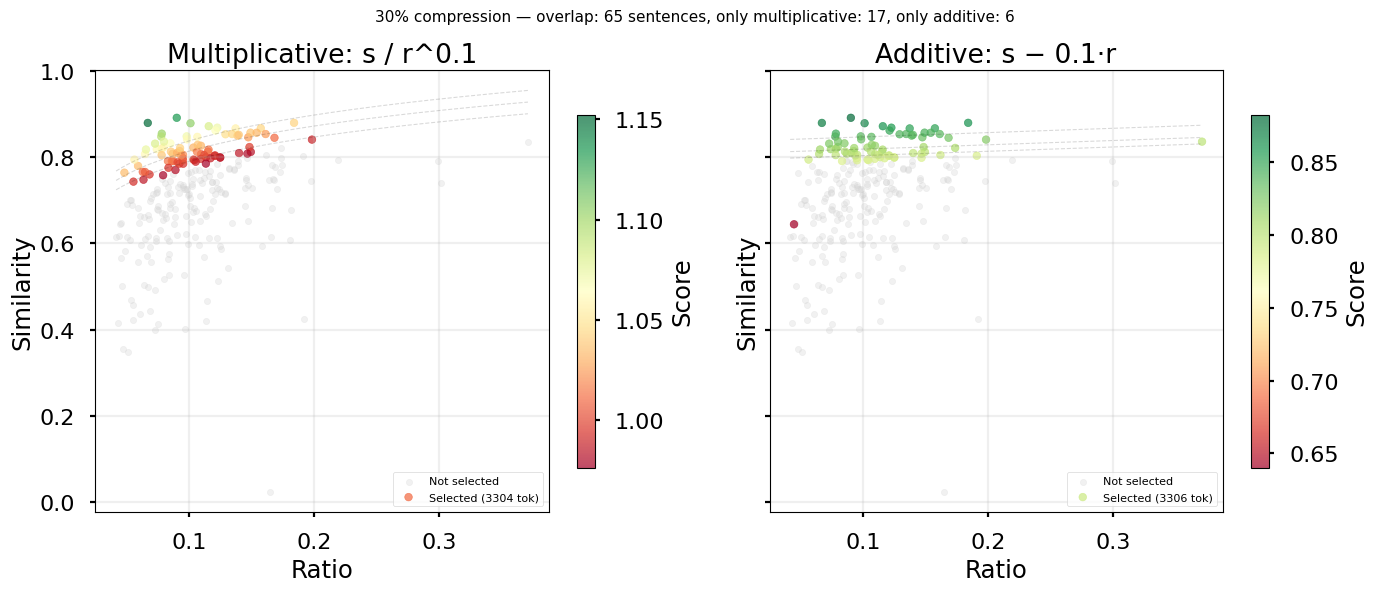

In [209]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.1
objective_percentage = 0.3

similarities = result['similarities']
ratios = result['ratios']
tokens = result['tokens']
total_tokens = int(np.sum(tokens))
objective_tokens = total_tokens * objective_percentage

# --- Scoring formulas ---
safe_ratios = np.maximum(ratios, 1e-9)
scores_multiplicative = similarities / np.power(safe_ratios, alpha)  # current
scores_additive = similarities - alpha * ratios                       # proposed

# --- Greedy selection for each ---
def greedy_select(scores, tokens, budget):
    mask = np.zeros(len(scores), dtype=bool)
    current = 0
    for idx in np.argsort(-scores):
        if current + tokens[idx] > budget:
            continue
        mask[idx] = True
        current += tokens[idx]
    return mask

mask_mult = greedy_select(scores_multiplicative, tokens, objective_tokens)
mask_add = greedy_select(scores_additive, tokens, objective_tokens)

# --- Visualisation ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, mask, scores, title in [
    (axes[0], mask_mult, scores_multiplicative, f"Multiplicative: s / r^{alpha}"),
    (axes[1], mask_add, scores_additive, f"Additive: s − {alpha}·r"),
]:
    # Unselected
    ax.scatter(
        ratios[~mask], similarities[~mask],
        color='lightgrey', alpha=0.3, s=20, label='Not selected',
    )
    # Selected, coloured by score
    sc = ax.scatter(
        ratios[mask], similarities[mask],
        c=scores[mask], cmap='RdYlGn', alpha=0.7, s=30,
        label=f'Selected ({int(np.sum(tokens[mask]))} tok)',
    )
    plt.colorbar(sc, ax=ax, label="Score", shrink=0.8)

    # Show iso-score contours
    r_grid = np.linspace(ratios.min(), ratios.max(), 200)
    if "Multiplicative" in title:
        for q in [0.25, 0.5, 0.75]:
            threshold = np.quantile(scores[mask], q)
            s_line = threshold * np.power(np.maximum(r_grid, 1e-9), alpha)
            ax.plot(r_grid, s_line, 'k--', alpha=0.15, linewidth=0.8)
    else:
        for q in [0.25, 0.5, 0.75]:
            threshold = np.quantile(scores[mask], q)
            s_line = threshold + alpha * r_grid
            ax.plot(r_grid, s_line, 'k--', alpha=0.15, linewidth=0.8)

    ax.set_xlabel("Ratio")
    ax.set_ylabel("Similarity")
    ax.set_title(title)
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    ax.grid(True, alpha=0.2)

# Overlap stats
both = mask_mult & mask_add
only_mult = mask_mult & ~mask_add
only_add = mask_add & ~mask_mult
fig.suptitle(
    f"30% compression — overlap: {both.sum()} sentences, "
    f"only multiplicative: {only_mult.sum()}, only additive: {only_add.sum()}",
    fontsize=11,
)
plt.tight_layout()
plt.show()

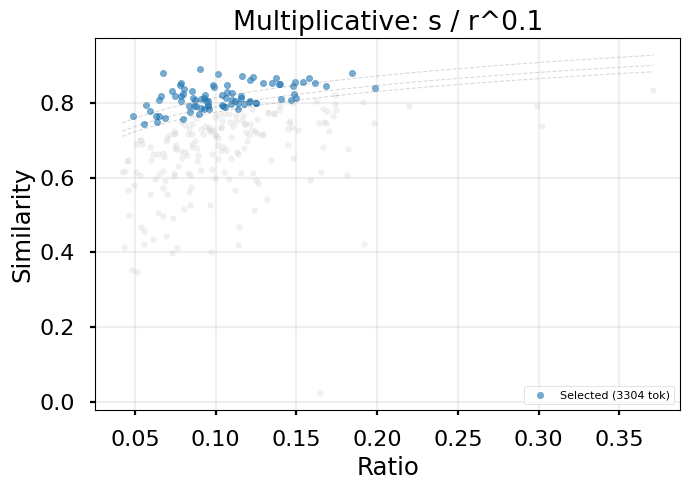

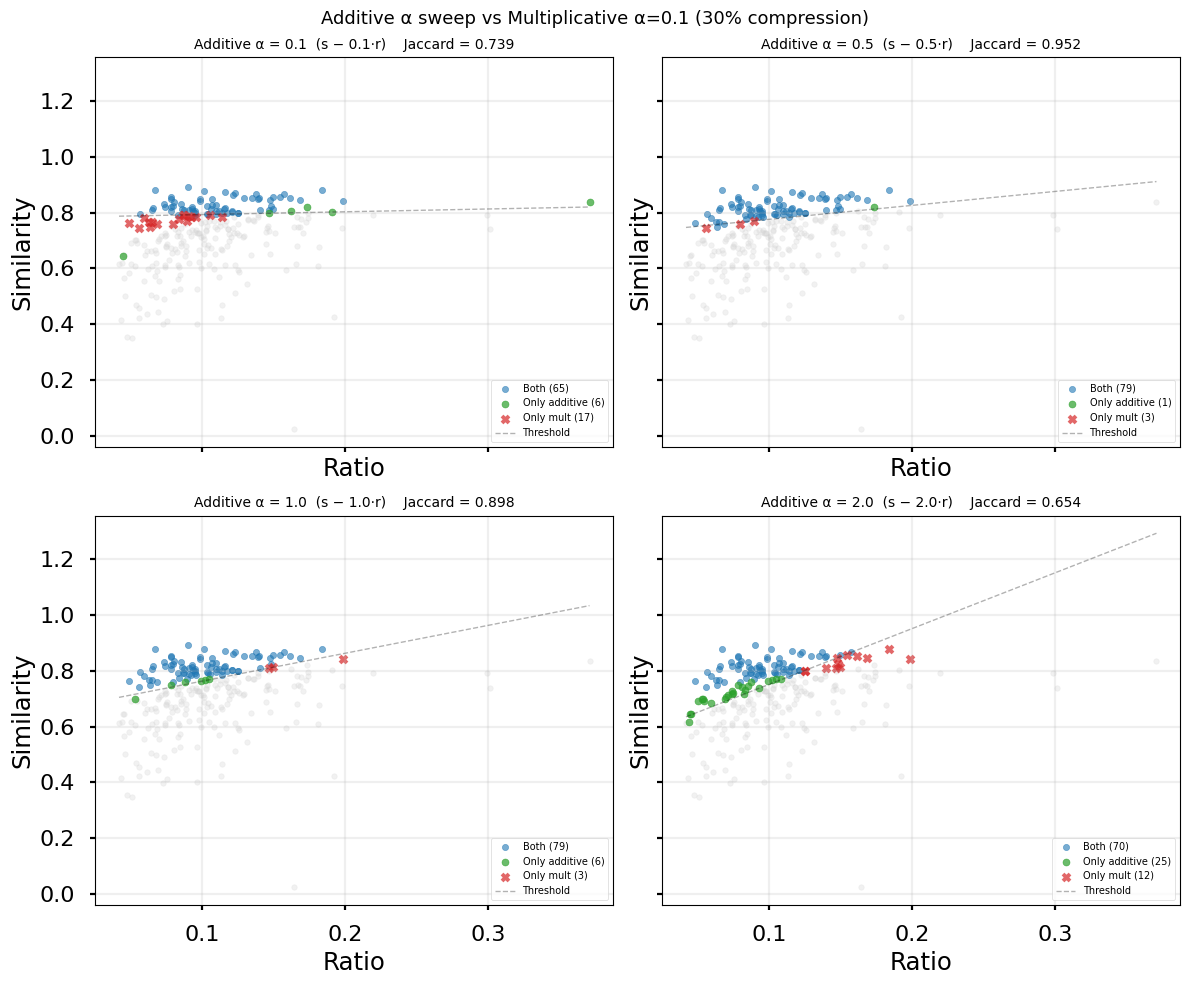

Additive α   Overlap   Only mult   Only add   Jaccard

-------------------------------------------------------

0.1        65          17          6     0.739

0.5        79           3          1     0.952

1.0        79           3          6     0.898

2.0        70          12         25     0.654

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Reference: multiplicative α=0.1
alpha_mult = 0.1
safe_ratios = np.maximum(result['ratios'], 1e-9)
scores_mult = result['similarities'] / np.power(safe_ratios, alpha_mult)
mask_mult = greedy_select(scores_mult, result['tokens'], objective_tokens)

# --- Standalone multiplicative plot ---
fig_mult, ax = plt.subplots(figsize=(7, 5))
ax.scatter(result['ratios'][~mask_mult], result['similarities'][~mask_mult],
           color='lightgrey', alpha=0.3, s=15)
ax.scatter(result['ratios'][mask_mult], result['similarities'][mask_mult],
           color='tab:blue', alpha=0.6, s=20,
           label=f'Selected ({int(np.sum(result["tokens"][mask_mult]))} tok)')
# Iso-score contours
r_grid = np.linspace(result['ratios'].min(), result['ratios'].max(), 200)
for q in [0.0, 0.25, 0.5]:
    thr = np.quantile(scores_mult[mask_mult], q)
    ax.plot(r_grid, thr * np.power(np.maximum(r_grid, 1e-9), alpha_mult),
            'k--', alpha=0.15, linewidth=0.8)
ax.set_xlabel("Ratio")
ax.set_ylabel("Similarity")
ax.set_title(f"Multiplicative: s / r^{alpha_mult}")
ax.legend(loc='lower right', fontsize=8, frameon=True)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# --- 2×2 additive α sweep ---
additive_alphas = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes_flat = axes.flatten()

overlaps = []
for i, alpha_add in enumerate(additive_alphas):
    ax = axes_flat[i]
    scores_add = result['similarities'] - alpha_add * result['ratios']
    mask_add = greedy_select(scores_add, result['tokens'], objective_tokens)

    overlap = (mask_mult & mask_add).sum()
    only_m = (mask_mult & ~mask_add).sum()
    only_a = (~mask_mult & mask_add).sum()
    overlaps.append((alpha_add, overlap, only_m, only_a))

    neither = ~mask_mult & ~mask_add
    ax.scatter(result['ratios'][neither], result['similarities'][neither],
               color='lightgrey', alpha=0.3, s=15)
    ax.scatter(result['ratios'][mask_mult & mask_add], result['similarities'][mask_mult & mask_add],
               color='tab:blue', alpha=0.6, s=20, label=f'Both ({overlap})')
    ax.scatter(result['ratios'][mask_add & ~mask_mult], result['similarities'][mask_add & ~mask_mult],
               color='tab:green', alpha=0.7, s=25, label=f'Only additive ({only_a})')
    ax.scatter(result['ratios'][mask_mult & ~mask_add], result['similarities'][mask_mult & ~mask_add],
               color='tab:red', alpha=0.7, s=25, marker='x', label=f'Only mult ({only_m})')

    # Threshold: use the highest score among non-selected sentences as the
    # decision boundary.  This is the "best sentence that didn't make it"
    # and visually separates selected from rejected better than the
    # minimum selected score (which can be dragged down by greedy tail-fill).
    non_selected_scores = scores_add[~mask_add]
    threshold = np.max(non_selected_scores) if non_selected_scores.size > 0 else np.min(scores_add)

    r_grid = np.linspace(result['ratios'].min(), result['ratios'].max(), 200)
    ax.plot(r_grid, threshold + alpha_add * r_grid, 'k--', alpha=0.3, linewidth=1,
            label='Threshold')

    ax.set_xlabel("Ratio")
    ax.set_ylabel("Similarity")
    jaccard = overlap / (overlap + only_m + only_a)
    ax.set_title(f"Additive α = {alpha_add}  (s − {alpha_add}·r)    Jaccard = {jaccard:.3f}", fontsize=10)
    ax.legend(loc='lower right', fontsize=7, frameon=True)
    ax.grid(True, alpha=0.2)

fig.suptitle("Additive α sweep vs Multiplicative α=0.1 (30% compression)", fontsize=13)
plt.tight_layout()
plt.show()

# Print overlap summary
print(f"\n{'Additive α':>12s}  {'Overlap':>8s}  {'Only mult':>10s}  {'Only add':>9s}  {'Jaccard':>8s}")
print("-" * 55)
for alpha_add, overlap, only_m, only_a in overlaps:
    jaccard = overlap / (overlap + only_m + only_a)
    print(f"{alpha_add:>12.1f}  {overlap:>8d}  {only_m:>10d}  {only_a:>9d}  {jaccard:>8.3f}")

## A/B: Additive α=0.5 vs α=0 (pure similarity)

Run the same ROUGE evaluation on 50 GovReport docs, but using the additive formula `score = similarity - α × ratio` with α=0.5 (equivalent to multiplicative α=0.1).

In [214]:
from rouge_score import rouge_scorer
import pandas as pd
import numpy as np

def compare_additive_bias(
    dataset,
    processor,
    objective_percentage: float = 0.3,
    alphas: list[float] = [0.0, 0.5],
):
    """Compare additive length_bias values: score = similarity - α × ratio."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    records = []

    for i, example in enumerate(dataset):
        text = example["report"]
        reference = example["summary"]

        # Compute features once per document
        features = processor.compute_document_features(text)
        total_tokens = int(np.sum(features["tokens"]))
        budget = total_tokens * objective_percentage

        row = {"doc": i}

        for alpha in alphas:
            scores = features["similarities"] - alpha * features["ratios"]

            # Greedy fill
            mask = np.zeros(len(scores), dtype=bool)
            current = 0
            for idx in np.argsort(-scores):
                if current + features["tokens"][idx] > budget:
                    continue
                mask[idx] = True
                current += features["tokens"][idx]

            selected_text = processor.select_sentences_with_separators(
                features["sentences"], mask.astype(int)
            )

            rouge = scorer.score(reference, selected_text)
            prefix = f"a{alpha}"
            row[f"{prefix}_tokens"] = int(np.sum(features["tokens"][mask]))
            row[f"{prefix}_rouge1"] = rouge["rouge1"].fmeasure
            row[f"{prefix}_rouge2"] = rouge["rouge2"].fmeasure
            row[f"{prefix}_rougeL"] = rouge["rougeL"].fmeasure

        records.append(row)
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")

    return pd.DataFrame(records)

df_add = compare_additive_bias(
    dataset=govreport,
    processor=processor,
    objective_percentage=0.3,
    alphas=[0.0, 0.5],
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [215]:
# Summary: additive α=0.5 vs α=0
summary_add = pd.DataFrame({
    "α = 0 (similarity only)": {
        "ROUGE-1": df_add["a0.0_rouge1"].mean(),
        "ROUGE-2": df_add["a0.0_rouge2"].mean(),
        "ROUGE-L": df_add["a0.0_rougeL"].mean(),
        "Avg tokens": df_add["a0.0_tokens"].mean(),
    },
    "Additive α = 0.5": {
        "ROUGE-1": df_add["a0.5_rouge1"].mean(),
        "ROUGE-2": df_add["a0.5_rouge2"].mean(),
        "ROUGE-L": df_add["a0.5_rougeL"].mean(),
        "Avg tokens": df_add["a0.5_tokens"].mean(),
    },
})
summary_add["Δ (α=0.5 − α=0)"] = summary_add["Additive α = 0.5"] - summary_add["α = 0 (similarity only)"]

print(f"Additive A/B over {len(df_add)} reports at 30% compression\n")
print(summary_add.to_string(float_format=lambda x: f"{x:.4f}"))

# Win rates
print(f"\n--- Win rates (additive α=0.5 > α=0) ---")
for metric in ["rouge1", "rouge2", "rougeL"]:
    wins = (df_add[f"a0.5_{metric}"] > df_add[f"a0.0_{metric}"]).sum()
    losses = (df_add[f"a0.5_{metric}"] < df_add[f"a0.0_{metric}"]).sum()
    ties = (df_add[f"a0.5_{metric}"] == df_add[f"a0.0_{metric}"]).sum()
    print(f"  {metric.upper():8s}: α=0.5 wins {wins}, α=0 wins {losses}, ties {ties}")

# Compare with multiplicative results (from earlier df)
print(f"\n--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---")
print(f"{'Metric':>10s}  {'Mult α=0.1':>12s}  {'Add α=0.5':>12s}  {'Δ':>8s}")
print("-" * 48)
for metric in ["rouge1", "rouge2", "rougeL"]:
    mult_val = df[f"a0.1_{metric}"].mean()
    add_val = df_add[f"a0.5_{metric}"].mean()
    print(f"  {metric.upper():8s}  {mult_val:>12.4f}  {add_val:>12.4f}  {add_val - mult_val:>+8.4f}")

Additive A/B over 50 reports at 30% compression

α = 0 (similarity only)  Additive α = 0.5  Δ (α=0.5 − α=0)
ROUGE-1                      0.3465            0.3475           0.0010
ROUGE-2                      0.1639            0.1649           0.0010
ROUGE-L                      0.1609            0.1638           0.0029
Avg tokens                2580.9600         2581.1400           0.1800

--- Win rates (additive α=0.5 > α=0) ---

ROUGE1  : α=0.5 wins 27, α=0 wins 22, ties 1

ROUGE2  : α=0.5 wins 26, α=0 wins 23, ties 1

ROUGEL  : α=0.5 wins 32, α=0 wins 17, ties 1

--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---

Metric    Mult α=0.1     Add α=0.5         Δ

------------------------------------------------

ROUGE1          0.3475        0.3475   -0.0000

ROUGE2          0.1652        0.1649   -0.0003

ROUGEL          0.1638        0.1638   -0.0000

## A/B: Embedding Model Comparison

All four minishlab **potion** models are distilled from the same teacher (`bge-base-en-v1.5`) and differ only in vocabulary size / parameter count:

| Model | Params | MTEB Avg (English) |
|---|---|---|
| `potion-base-2M` | 2 M | 44.77 |
| `potion-base-4M` | 4 M | 48.23 |
| `potion-base-8M` | 8 M | 50.03 |
| `potion-base-32M` | 32 M | 51.66 |

**Hypothesis:** Because SentenceMapper only uses *relative* cosine similarity (sentence vs. its own context window), the ranking of sentences should be largely model-invariant.  A weaker model produces noisier embeddings, but the *ranking* of sentences by representativeness may be preserved — meaning ROUGE scores stay flat across models.

**Design:**
- Same 50 GovReport documents, 30% compression, additive α = 0.5.
- One `SentenceProcessor` per model (sentence splitting is deterministic — only embeddings change).
- ROUGE-1 / ROUGE-2 / ROUGE-L of selected text vs. human reference.
- Pairwise Jaccard overlap of selected sentence sets to quantify agreement.
- Wall-clock embedding time per model.

In [301]:
import time

import numpy as np
import pandas as pd
from rouge_score import rouge_scorer

from src.sentence_processor import SentenceProcessor

MODELS = [
    "minishlab/potion-base-2M",
    "minishlab/potion-base-4M",
    "minishlab/potion-base-8M",
    "minishlab/potion-base-32M",
]

ALPHA = 0.5
OBJECTIVE_PCT = 0.3

# Pre-load one processor per model (sentence splitting is shared config)
processors = {}
for model_name in MODELS:
    print(f"Loading {model_name}...")
    processors[model_name] = SentenceProcessor(
        embedding_model_name=model_name,
        context_budget=2048,
        min_sentence_length=256,
        custom_parameters=custom_parameters,   # reuse GovReport abbreviations
    )
print("All models loaded.")

Loading minishlab/potion-base-2M...

Loading minishlab/potion-base-4M...

model.safetensors:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading minishlab/potion-base-8M...

Loading minishlab/potion-base-32M...

All models loaded.

In [302]:
def compare_embedding_models(
    dataset,
    processors: dict[str, SentenceProcessor],
    objective_percentage: float = 0.3,
    alpha: float = 0.5,
):
    """Compare embedding models on extractive selection quality.

    For each document, every processor computes features independently
    (sentence splitting is deterministic — only embeddings differ).
    Sentences are scored with `similarity - α × ratio` and greedily selected.

    Returns a DataFrame with ROUGE scores, selected tokens, embedding time,
    and pairwise Jaccard overlaps between models.
    """
    scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL"], use_stemmer=True
    )
    model_names = list(processors.keys())
    records = []

    for i, example in enumerate(dataset):
        text = example["report"]
        reference = example["summary"]
        row = {"doc": i}

        masks = {}   # model_name → binary mask
        for model_name, proc in processors.items():
            short = model_name.split("/")[-1]   # e.g. "potion-base-8M"

            t0 = time.perf_counter()
            features = proc.compute_document_features(text)
            embed_time = time.perf_counter() - t0

            total_tokens = int(np.sum(features["tokens"]))
            budget = total_tokens * objective_percentage

            scores = features["similarities"] - alpha * features["ratios"]

            # Greedy fill
            mask = np.zeros(len(scores), dtype=bool)
            current = 0
            for idx in np.argsort(-scores):
                if current + features["tokens"][idx] > budget:
                    continue
                mask[idx] = True
                current += features["tokens"][idx]

            selected_text = proc.select_sentences_with_separators(
                features["sentences"], mask.astype(int)
            )

            rouge = scorer.score(reference, selected_text)
            row[f"{short}_tokens"] = int(np.sum(features["tokens"][mask]))
            row[f"{short}_rouge1"] = rouge["rouge1"].fmeasure
            row[f"{short}_rouge2"] = rouge["rouge2"].fmeasure
            row[f"{short}_rougeL"] = rouge["rougeL"].fmeasure
            row[f"{short}_time"] = embed_time

            masks[short] = mask

        # Pairwise Jaccard overlaps
        shorts = list(masks.keys())
        for a_idx in range(len(shorts)):
            for b_idx in range(a_idx + 1, len(shorts)):
                a, b = shorts[a_idx], shorts[b_idx]
                intersection = (masks[a] & masks[b]).sum()
                union = (masks[a] | masks[b]).sum()
                jaccard = intersection / union if union > 0 else 1.0
                row[f"jaccard_{a}_vs_{b}"] = jaccard

        records.append(row)
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")

    return pd.DataFrame(records)

df_models = compare_embedding_models(
    dataset=govreport,
    processors=processors,
    objective_percentage=OBJECTIVE_PCT,
    alpha=ALPHA,
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [303]:
# ── Summary table: ROUGE scores & embedding time per model ──

model_shorts = [m.split("/")[-1] for m in MODELS]

summary_models = pd.DataFrame({
    short: {
        "ROUGE-1": df_models[f"{short}_rouge1"].mean(),
        "ROUGE-2": df_models[f"{short}_rouge2"].mean(),
        "ROUGE-L": df_models[f"{short}_rougeL"].mean(),
        "Avg tokens": df_models[f"{short}_tokens"].mean(),
        "Embed time (s)": df_models[f"{short}_time"].mean(),
    }
    for short in model_shorts
})

print(f"Embedding model A/B over {len(df_models)} reports at {OBJECTIVE_PCT:.0%} compression (α={ALPHA})\n")
print(summary_models.to_string(float_format=lambda x: f"{x:.4f}"))

# ── Pairwise Jaccard overlap ──
print(f"\n--- Average pairwise Jaccard overlap ---")
jaccard_cols = [c for c in df_models.columns if c.startswith("jaccard_")]
for col in jaccard_cols:
    pair = col.replace("jaccard_", "")
    print(f"  {pair:45s}: {df_models[col].mean():.4f}")

# ── Win rates: best model per document ──
print(f"\n--- Win counts (best ROUGE-L per document) ---")
rougeL_cols = {short: f"{short}_rougeL" for short in model_shorts}
rougeL_df = df_models[list(rougeL_cols.values())]
rougeL_df.columns = list(rougeL_cols.keys())
winner = rougeL_df.idxmax(axis=1)
print(winner.value_counts().to_string())

Embedding model A/B over 50 reports at 30% compression (α=0.5)

potion-base-2M  potion-base-4M  potion-base-8M  potion-base-32M
ROUGE-1                 0.3481          0.3490          0.3475           0.3476
ROUGE-2                 0.1643          0.1663          0.1649           0.1635
ROUGE-L                 0.1618          0.1644          0.1638           0.1617
Avg tokens           2580.2800       2581.4600       2581.1400        2580.9800
Embed time (s)          0.0627          0.0623          0.0654           0.0729

--- Average pairwise Jaccard overlap ---

potion-base-2M_vs_potion-base-4M             : 0.7591

potion-base-2M_vs_potion-base-8M             : 0.6830

potion-base-2M_vs_potion-base-32M            : 0.6167

potion-base-4M_vs_potion-base-8M             : 0.8185

potion-base-4M_vs_potion-base-32M            : 0.6983

potion-base-8M_vs_potion-base-32M            : 0.7619

--- Win counts (best ROUGE-L per document) ---

potion-base-2M     17
potion-base-8M     13
potion-base-32M    11
potion-base-4M      9

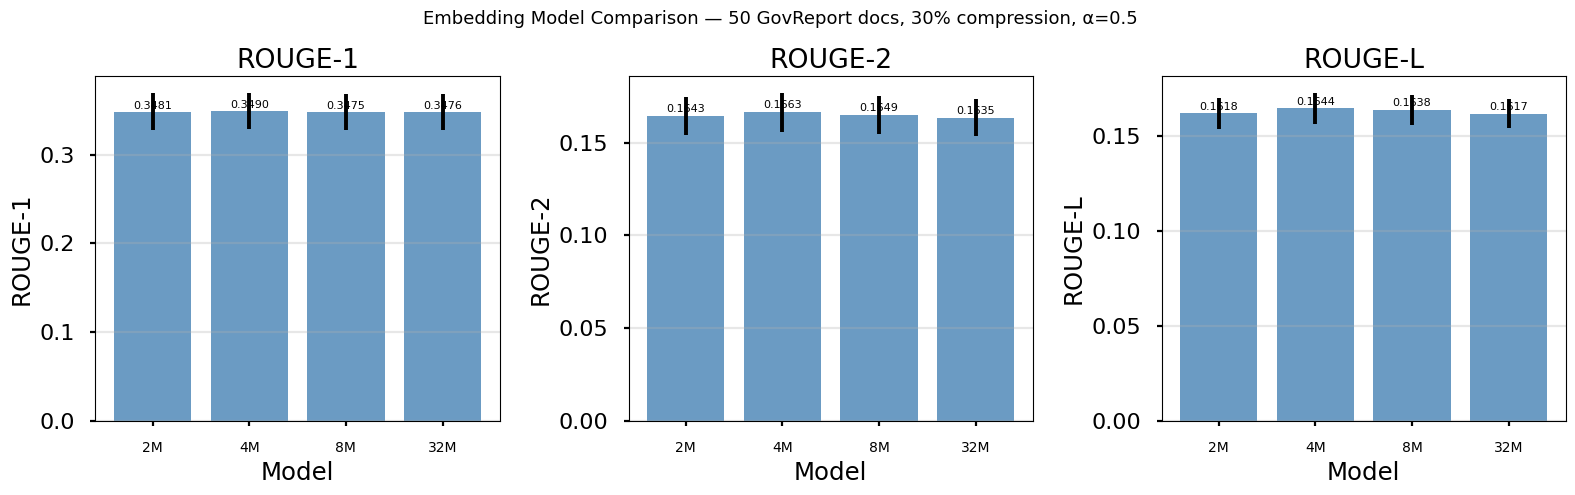

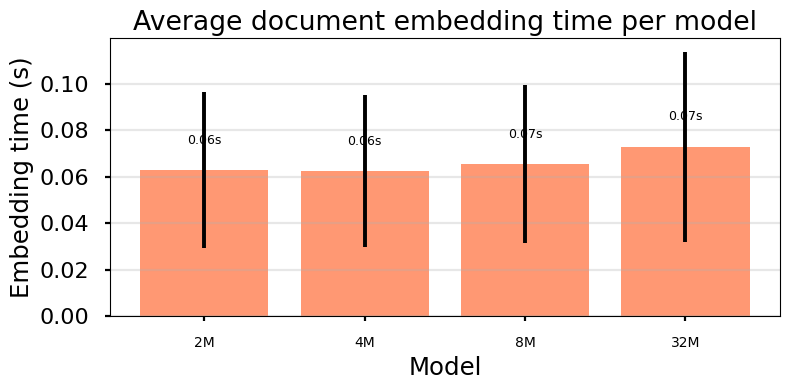

In [304]:
import matplotlib.pyplot as plt

model_shorts = [m.split("/")[-1] for m in MODELS]
metrics = ["rouge1", "rouge2", "rougeL"]
metric_labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

for ax, metric, label in zip(axes, metrics, metric_labels):
    means = [df_models[f"{s}_{metric}"].mean() for s in model_shorts]
    stds = [df_models[f"{s}_{metric}"].std() for s in model_shorts]
    sems = [s / np.sqrt(len(df_models)) for s in stds]

    x = range(len(model_shorts))
    bars = ax.bar(x, means, yerr=sems, capsize=4, color="steelblue", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([s.replace("potion-base-", "") for s in model_shorts], fontsize=10)
    ax.set_xlabel("Model")
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.grid(axis="y", alpha=0.3)

    # Annotate bars
    for bar, m in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                f"{m:.4f}", ha="center", va="bottom", fontsize=8)

fig.suptitle(
    f"Embedding Model Comparison — {len(df_models)} GovReport docs, "
    f"{OBJECTIVE_PCT:.0%} compression, α={ALPHA}",
    fontsize=13,
)
plt.tight_layout()
plt.show()

# ── Embedding time comparison ──
fig2, ax2 = plt.subplots(figsize=(8, 4))
times = [df_models[f"{s}_time"].mean() for s in model_shorts]
time_stds = [df_models[f"{s}_time"].std() for s in model_shorts]
bars = ax2.bar(range(len(model_shorts)), times, yerr=time_stds, capsize=4,
               color="coral", alpha=0.8)
ax2.set_xticks(range(len(model_shorts)))
ax2.set_xticklabels([s.replace("potion-base-", "") for s in model_shorts], fontsize=10)
ax2.set_xlabel("Model")
ax2.set_ylabel("Embedding time (s)")
ax2.set_title("Average document embedding time per model")
ax2.grid(axis="y", alpha=0.3)
for bar, t in zip(bars, times):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{t:.2f}s", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

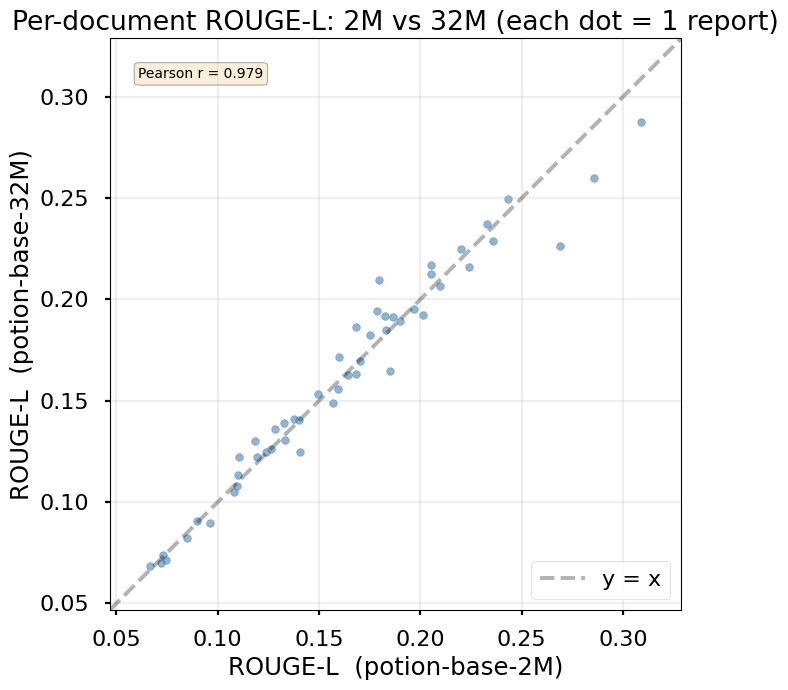

In [305]:
# ── Per-document ROUGE-L scatter: smallest vs largest model ──

fig, ax = plt.subplots(figsize=(7, 7))
x = df_models["potion-base-2M_rougeL"]
y = df_models["potion-base-32M_rougeL"]

ax.scatter(x, y, alpha=0.6, s=30, color="steelblue")
lims = [min(x.min(), y.min()) - 0.02, max(x.max(), y.max()) + 0.02]
ax.plot(lims, lims, "k--", alpha=0.3, label="y = x")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("ROUGE-L  (potion-base-2M)")
ax.set_ylabel("ROUGE-L  (potion-base-32M)")
ax.set_title("Per-document ROUGE-L: 2M vs 32M (each dot = 1 report)")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.2)

# Pearson correlation
corr = np.corrcoef(x, y)[0, 1]
ax.text(0.05, 0.95, f"Pearson r = {corr:.3f}", transform=ax.transAxes,
        fontsize=10, verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()

In [306]:
from scipy.stats import spearmanr
from itertools import combinations

model_shorts = [m.split("/")[-1] for m in MODELS]
pairs = list(combinations(model_shorts, 2))

# For each document, compute features per model and store similarity & score vectors
records = []
for i, example in enumerate(govreport):
    text = example["report"]

    vecs = {}  # short → (similarities, scores)
    for model_name, proc in processors.items():
        short = model_name.split("/")[-1]
        features = proc.compute_document_features(text)
        sims = features["similarities"]
        scores = sims - ALPHA * features["ratios"]
        vecs[short] = (sims, scores)

    row = {"doc": i}
    for a, b in pairs:
        # Spearman on raw similarities
        rho_sim, _ = spearmanr(vecs[a][0], vecs[b][0])
        # Spearman on final scores (similarity - α·ratio)
        rho_score, _ = spearmanr(vecs[a][1], vecs[b][1])
        row[f"spearman_sim_{a}_vs_{b}"] = rho_sim
        row[f"spearman_score_{a}_vs_{b}"] = rho_score

    records.append(row)
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(govreport)} reports...")

df_spearman = pd.DataFrame(records)

# ── Summary ──
print(f"\n{'Pair':>45s}  {'ρ (similarity)':>16s}  {'ρ (score)':>12s}")
print("-" * 80)
for a, b in pairs:
    rho_sim = df_spearman[f"spearman_sim_{a}_vs_{b}"].mean()
    rho_score = df_spearman[f"spearman_score_{a}_vs_{b}"].mean()
    print(f"  {a} vs {b:>20s}  {rho_sim:>16.4f}  {rho_score:>12.4f}")

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

Pair    ρ (similarity)     ρ (score)

--------------------------------------------------------------------------------

potion-base-2M vs       potion-base-4M            0.9638        0.9604

potion-base-2M vs       potion-base-8M            0.9364        0.9306

potion-base-2M vs      potion-base-32M            0.8865        0.8762

potion-base-4M vs       potion-base-8M            0.9828        0.9815

potion-base-4M vs      potion-base-32M            0.9405        0.9353

potion-base-8M vs      potion-base-32M            0.9632        0.9602

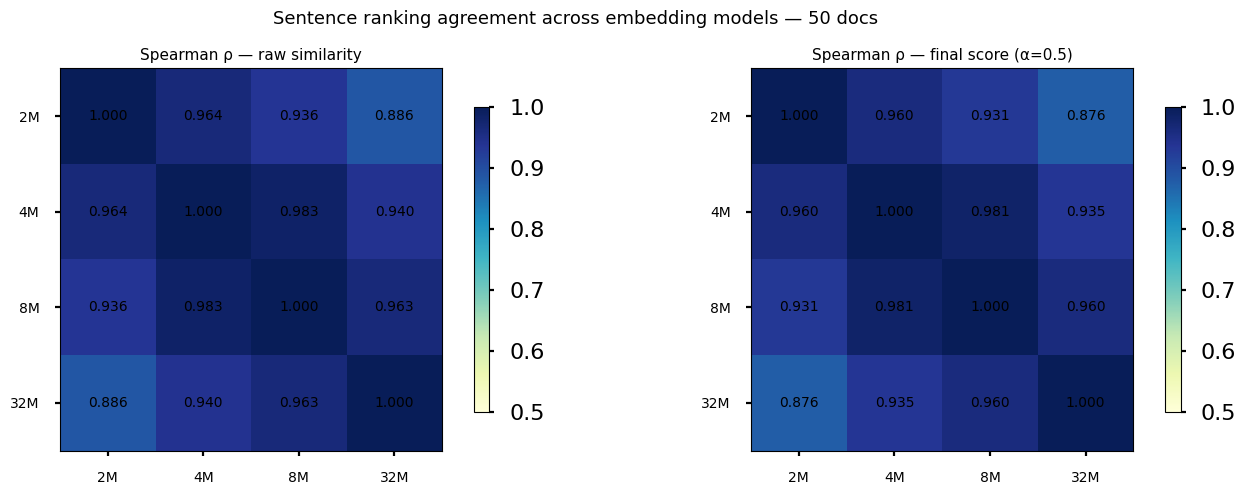

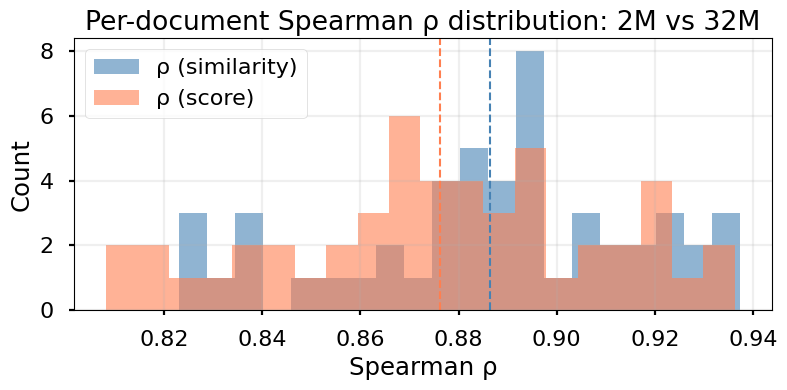

In [307]:
# ── Spearman ρ heatmap: similarity ranking agreement ──

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, signal, title in [
    (axes[0], "sim", "Spearman ρ — raw similarity"),
    (axes[1], "score", f"Spearman ρ — final score (α={ALPHA})"),
]:
    # Build symmetric matrix
    n = len(model_shorts)
    mat = np.ones((n, n))
    for a_idx in range(n):
        for b_idx in range(a_idx + 1, n):
            a, b = model_shorts[a_idx], model_shorts[b_idx]
            val = df_spearman[f"spearman_{signal}_{a}_vs_{b}"].mean()
            mat[a_idx, b_idx] = val
            mat[b_idx, a_idx] = val

    im = ax.imshow(mat, vmin=0.5, vmax=1.0, cmap="YlGnBu", aspect="equal")
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    labels = [s.replace("potion-base-", "") for s in model_shorts]
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_title(title, fontsize=11)

    # Annotate cells
    for ii in range(n):
        for jj in range(n):
            ax.text(jj, ii, f"{mat[ii, jj]:.3f}", ha="center", va="center",
                    fontsize=10, color="white" if mat[ii, jj] < 0.75 else "black")

    plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle(
    f"Sentence ranking agreement across embedding models — {len(df_spearman)} docs",
    fontsize=13,
)
plt.tight_layout()
plt.show()

# ── Distribution of per-document Spearman ρ (2M vs 32M) ──
fig2, ax2 = plt.subplots(figsize=(8, 4))
col_sim = f"spearman_sim_potion-base-2M_vs_potion-base-32M"
col_score = f"spearman_score_potion-base-2M_vs_potion-base-32M"
ax2.hist(df_spearman[col_sim], bins=20, alpha=0.6, label="ρ (similarity)", color="steelblue")
ax2.hist(df_spearman[col_score], bins=20, alpha=0.6, label="ρ (score)", color="coral")
ax2.axvline(df_spearman[col_sim].mean(), color="steelblue", linestyle="--", linewidth=1.5)
ax2.axvline(df_spearman[col_score].mean(), color="coral", linestyle="--", linewidth=1.5)
ax2.set_xlabel("Spearman ρ")
ax2.set_ylabel("Count")
ax2.set_title("Per-document Spearman ρ distribution: 2M vs 32M")
ax2.legend()
ax2.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## A/B: LLM Summary Quality — 2M vs 32M

The previous experiments showed that ROUGE on *extracted text* and Spearman rank correlation are nearly identical across embedding models. But does this hold when we add the LLM abstraction step?

**Design:**
- 10 GovReport documents, 30% compression, α = 0.5.
- For each document, extract sentences with **potion-base-2M** and **potion-base-32M**.
- Pass each extraction to `gpt-4.1` to generate a summary.
- Evaluate with ROUGE (vs human reference) and LLM judge (`gpt-5`).
- Compare scores pairwise across models.

In [319]:
import time
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer

AB_MODELS = ["minishlab/potion-base-2M", "minishlab/potion-base-32M"]
N_DOCS = 10

# Create a pipeline per model
pipelines = {}
for model_name in AB_MODELS:
    short = model_name.split("/")[-1]
    pipelines[short] = SentenceMapperPipeline(
        embedding_model_name=model_name,
        context_budget=2048,
        min_sentence_length=256,
        custom_parameters=custom_parameters,
        length_bias=ALPHA,
    )
    print(f"Pipeline loaded: {short}")

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

def judge_with_retry(summarizer, generated, reference, compression, retries=2):
    """Call judge_with_llm, retrying on empty responses."""
    for attempt in range(retries + 1):
        evaluation = summarizer.judge_with_llm(
            generated_summary=generated,
            reference_summary=reference,
            compression_ratio=compression,
        )
        if evaluation.get("overall_score") is not None:
            return evaluation
        if attempt < retries:
            print(f"    ⚠ Empty judge response, retrying ({attempt + 1}/{retries})...")
            time.sleep(2)
    return evaluation  # return last attempt even if failed

records = []

for i in range(N_DOCS):
    text = govreport[i]["report"]
    reference = govreport[i]["summary"]
    row = {"doc": i}

    # ── Step 1: Extract sentences with each model via pipeline ──
    extractions = {}
    for short, pipe in pipelines.items():
        result = pipe.process_document(text, objective_percentage=OBJECTIVE_PCT)
        extractions[short] = result["selected_text"]

    # ── Step 2: Generate LLM summaries & evaluate with ROUGE ──
    for short, selected_text in extractions.items():
        llm_summary = summarizer.summarize_with_llm(text=selected_text)

        rouge = scorer.score(reference, llm_summary)
        row[f"{short}_rouge1"] = rouge["rouge1"].fmeasure
        row[f"{short}_rouge2"] = rouge["rouge2"].fmeasure
        row[f"{short}_rougeL"] = rouge["rougeL"].fmeasure
        row[f"{short}_summary"] = llm_summary

    # ── Step 3: LLM judge on both summaries ──
    for short in extractions:
        evaluation = judge_with_retry(
            summarizer,
            generated=row[f"{short}_summary"],
            reference=reference,
            compression=OBJECTIVE_PCT * 100,
        )
        row[f"{short}_judge_score"] = evaluation.get("overall_score", None)
        row[f"{short}_judge"] = evaluation

    records.append(row)
    print(f"  Doc {i}: 2M judge={row.get('potion-base-2M_judge_score')}, "
          f"32M judge={row.get('potion-base-32M_judge_score')}")

df_llm_ab = pd.DataFrame(records)
print(f"\nDone — {N_DOCS} documents processed.")

Pipeline loaded: potion-base-2M

Pipeline loaded: potion-base-32M

Doc 0: 2M judge=7, 32M judge=7

Doc 1: 2M judge=7, 32M judge=7

Doc 2: 2M judge=7, 32M judge=7

Doc 3: 2M judge=7, 32M judge=7

Doc 4: 2M judge=7, 32M judge=7

Doc 5: 2M judge=7, 32M judge=7

⚠ Empty judge response, retrying (1/2)...

Doc 6: 2M judge=7, 32M judge=7

Doc 7: 2M judge=7, 32M judge=7

Doc 8: 2M judge=7, 32M judge=7

Doc 9: 2M judge=7, 32M judge=7

Done — 10 documents processed.

In [320]:
# ── Summary table ──
shorts = [m.split("/")[-1] for m in AB_MODELS]

summary_llm = pd.DataFrame({
    short: {
        "ROUGE-1": df_llm_ab[f"{short}_rouge1"].mean(),
        "ROUGE-2": df_llm_ab[f"{short}_rouge2"].mean(),
        "ROUGE-L": df_llm_ab[f"{short}_rougeL"].mean(),
        "Judge score": df_llm_ab[f"{short}_judge_score"].mean(),
    }
    for short in shorts
})
summary_llm["Δ (2M − 32M)"] = summary_llm[shorts[0]] - summary_llm[shorts[1]]

print(f"LLM Summary A/B — {N_DOCS} docs, {OBJECTIVE_PCT:.0%} compression, α={ALPHA}\n")
print(summary_llm.to_string(float_format=lambda x: f"{x:.4f}"))

# ── Per-document comparison ──
print(f"\n{'Doc':>4s}  {'2M ROUGE-L':>11s}  {'32M ROUGE-L':>12s}  {'2M Judge':>9s}  {'32M Judge':>10s}")
print("-" * 55)
for _, row in df_llm_ab.iterrows():
    print(f"{int(row['doc']):>4d}  "
          f"{row['potion-base-2M_rougeL']:>11.4f}  "
          f"{row['potion-base-32M_rougeL']:>12.4f}  "
          f"{row['potion-base-2M_judge_score']:>9}  "
          f"{row['potion-base-32M_judge_score']:>10}")

# ── Win rates ──
print(f"\n--- Win rates (2M vs 32M) ---")
for metric, label in [("rougeL", "ROUGE-L"), ("judge_score", "Judge")]:
    col_2m = f"potion-base-2M_{metric}"
    col_32m = f"potion-base-32M_{metric}"
    wins_2m = (df_llm_ab[col_2m] > df_llm_ab[col_32m]).sum()
    wins_32m = (df_llm_ab[col_2m] < df_llm_ab[col_32m]).sum()
    ties = (df_llm_ab[col_2m] == df_llm_ab[col_32m]).sum()
    print(f"  {label:>10s}: 2M wins {wins_2m}, 32M wins {wins_32m}, ties {ties}")

LLM Summary A/B — 10 docs, 30% compression, α=0.5

potion-base-2M  potion-base-32M  Δ (2M − 32M)
ROUGE-1              0.4766           0.4858       -0.0092
ROUGE-2              0.1335           0.1336       -0.0001
ROUGE-L              0.1826           0.1878       -0.0052
Judge score          7.0000           7.0000        0.0000

Doc   2M ROUGE-L   32M ROUGE-L   2M Judge   32M Judge

-------------------------------------------------------

0       0.2204        0.2367          7           7

1       0.1487        0.1634          7           7

2       0.2534        0.2431          7           7

3       0.1881        0.1836          7           7

4       0.1163        0.1075          7           7

5       0.1904        0.2059          7           7

6       0.1980        0.2019          7           7

7       0.1656        0.1667          7           7

8       0.1606        0.1947          7           7

9       0.1847        0.1751          7           7

--- Win rates (2M vs 32M) ---

ROUGE-L: 2M wins 4, 32M wins 6, ties 0

Judge: 2M wins 0, 32M wins 0, ties 10

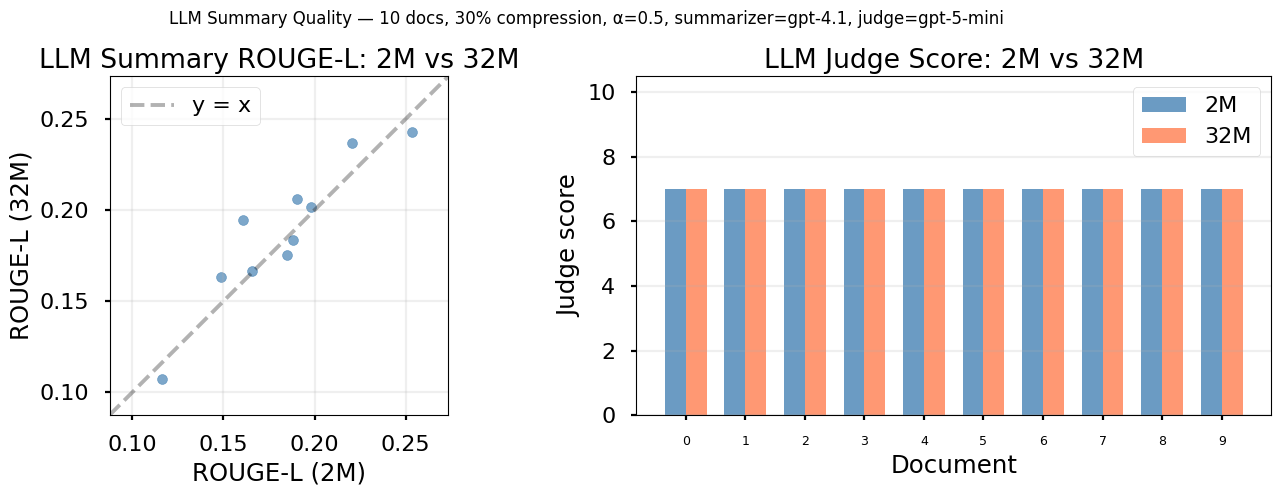

In [321]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Left: ROUGE-L scatter ──
ax = axes[0]
x = df_llm_ab["potion-base-2M_rougeL"]
y = df_llm_ab["potion-base-32M_rougeL"]
ax.scatter(x, y, s=50, alpha=0.7, color="steelblue")
lims = [min(x.min(), y.min()) - 0.02, max(x.max(), y.max()) + 0.02]
ax.plot(lims, lims, "k--", alpha=0.3, label="y = x")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("ROUGE-L (2M)")
ax.set_ylabel("ROUGE-L (32M)")
ax.set_title("LLM Summary ROUGE-L: 2M vs 32M")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.2)

# ── Right: Judge score comparison ──
ax = axes[1]
doc_ids = df_llm_ab["doc"].astype(int)
width = 0.35
x_pos = np.arange(len(doc_ids))
ax.bar(x_pos - width/2, df_llm_ab["potion-base-2M_judge_score"], width,
       label="2M", color="steelblue", alpha=0.8)
ax.bar(x_pos + width/2, df_llm_ab["potion-base-32M_judge_score"], width,
       label="32M", color="coral", alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(doc_ids, fontsize=9)
ax.set_xlabel("Document")
ax.set_ylabel("Judge score")
ax.set_title("LLM Judge Score: 2M vs 32M")
ax.set_ylim(0, 10.5)
ax.legend()
ax.grid(axis="y", alpha=0.2)

fig.suptitle(
    f"LLM Summary Quality — {N_DOCS} docs, {OBJECTIVE_PCT:.0%} compression, "
    f"α={ALPHA}, summarizer={summarizer.summarize_model}, judge={summarizer.judge_model}",
    fontsize=12,
)
plt.tight_layout()
plt.show()

In [322]:
evaluation

{'strengths': 'The generated summary clearly defines unregulated child custody transfers ("rehoming") and explains why they raise child-safety concerns. It concisely covers the main adoption pathways (foster, private domestic, international) and contrasts their training and oversight requirements. It discusses key drivers for families considering unregulated transfers (child trauma/behavioral needs, lack of post-adoption services), highlights variability in pre- and post-adoption supports across states, and summarizes state and federal responses (criminalization, awareness efforts, HHS/State collaboration). The summary is generally well organized and draws on the report’s evidence base (interviews, agency review) to support its points.',
 'gaps': 'Important omissions include: 1) Prevalence and data limitations: the reference notes GAO found little is known about prevalence, that no federal agency tracks these transfers, and GAO identified 23 online posts over a 15-month period — the ge